In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os

import awkward as ak
import uproot
import numpy as np
import glob
from coffea.nanoevents import NanoEventsFactory, BaseSchema, NanoAODSchema
from coffea import hist, processor
# register our candidate behaviors
from coffea.nanoevents.methods import candidate
ak.behavior.update(candidate.behavior)

from functools import partial

from tools.helpers import get_four_vec_fromPtEtaPhiM, match

from yahist import Hist1D, Hist2D

import json

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import mplhep as hep

plt.style.use(hep.style.CMS)  # or ATLAS/LHCb

In [3]:
from tools.helpers import dasWrapper
from analysis.tagger import desired_output

redirector_ucsd = 'root://xcache-redirector.t2.ucsd.edu:2042/'
redirector_fnal = 'root://cmsxrootd.fnal.gov/'

# maybe we'll need the number of events for weighting, but not at the moment
def get_nevents(name):
    res = dasWrapper(name, query='summary')
    return json.loads(res[0])[0]['nevents']


In [4]:
samples_signal = [
    '/ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2/NANOAODSIM',
]

Z_samples = [
    '/ZJetsToNuNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/ZJetsToNuNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/ZJetsToNuNu_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/ZJetsToNuNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/ZJetsToNuNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/ZJetsToNuNu_HT-1200To2500_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/ZJetsToNuNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
]

tt_samples = [
    '/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    #'/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/TT_Mtt-1000toInf_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2/NANOAODSIM',
    '/ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2/NANOAODSIM',
    '/ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
]

QCD_samples = [
    '/QCD_bEnriched_HT100to200_TuneCP5_13TeV-madgraph-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/QCD_bEnriched_HT200to300_TuneCP5_13TeV-madgraph-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/QCD_bEnriched_HT300to500_TuneCP5_13TeV-madgraph-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/QCD_bEnriched_HT500to700_TuneCP5_13TeV-madgraph-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/QCD_bEnriched_HT700to1000_TuneCP5_13TeV-madgraph-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/QCD_bEnriched_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/QCD_bEnriched_HT1500to2000_TuneCP5_13TeV-madgraph-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/QCD_bEnriched_HT2000toInf_TuneCP5_13TeV-madgraph-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
]

W_samples = [
    #'/W0JetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM'
    #'/W1JetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    #'/W2JetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    #'/W3JetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    #'/W4JetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2/NANOAODSIM',
    '/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM'
]

rare_samples = [
    '',
]

In [5]:
fileset_signal = {s.split('/')[1]: [redirector_fnal+p for p in dasWrapper(s)] for s in samples_signal}
fileset_Z = {s.split('/')[1]: [redirector_ucsd+p for p in dasWrapper(s)] for s in Z_samples}
fileset_QCD = {s.split('/')[1]: [redirector_ucsd+p for p in dasWrapper(s)] for s in QCD_samples}
fileset_W = {s.split('/')[1]: [redirector_ucsd+p for p in dasWrapper(s)] for s in W_samples}
fileset_tt = {s.split('/')[1]: [redirector_ucsd+p for p in dasWrapper(s)][:10] for s in tt_samples}

In [6]:
exe_args = {
    'workers': 12,
    "schema": NanoAODSchema,
    "skipbadfiles": True,
}
exe = processor.futures_executor

fileset = fileset_tt



## Mass resolutions

### Run 2 FullSim

In [7]:
fileset_signal;

In [104]:
ev = NanoEventsFactory.from_root(
        '6BF93845-49D5-2547-B860-4F7601074715.root',
        #'/nfs-7/userdata/dspitzba/ZJetsToNuNu_HT-200To400_14TeV-madgraph_200PU//ZJetsToNuNu_HT-200To400_14TeV-madgraph_200PU_1.root',
        #'/hadoop/cms/store/user/dspitzba/ProjectMetis/WJetsToLNu_GenMET-100_TuneCUETP8M1_14TeV-madgraphMLM-pythia8_200PU_v16/skim_13.root',
        treepath='Events',
        schemaclass=NanoAODSchema,
    ).events()

In [105]:
from tools.helpers import get_four_vec_fromPtEtaPhiM, match, delta_r, delta_r2, yahist_2D_lookup



def match_count(first, second, deltaRCut=0.4):
    drCut2 = deltaRCut**2
    combs = ak.cartesian([first, second], nested=True)
    return ak.sum((delta_r2(combs['0'], combs['1'])<drCut2), axis=2)

In [106]:
fat = ev.FatJet[
    (ev.FatJet.pt>300) &\
    (abs(ev.FatJet.eta)<2.4) &\
    (ev.FatJet.jetId>0)
]

higgs = ev.GenPart[((abs(ev.GenPart.pdgId)==25)&(ev.GenPart.status==62))]

bquark = ev.GenPart[((abs(ev.GenPart.pdgId)==5)&(ev.GenPart.status==71))]

nb_in_fat = match_count(fat, bquark, deltaRCut=0.8)

nhiggs_in_fat = match_count(fat, higgs, deltaRCut=0.8)

In [107]:
h_mSD_res_full = Hist1D(
    np.abs(ak.flatten(fat[((nhiggs_in_fat>0)&(nb_in_fat>1))].msoftdrop)-125),
    bins=np.linspace(0,100,21)
)
h_mSD_res_full

[425.00 ± 20.62   362.00 ± 19.03   292.00 ± 17.09   247.00 ± 15.72
 190.00 ± 13.78   148.00 ± 12.17   115.00 ± 10.72   104.00 ± 10.20
 102.00 ± 10.10   86.00 ± 9.27   68.00 ± 8.25   56.00 ± 7.48
 57.00 ± 7.55   72.00 ± 8.49   52.00 ± 7.21   43.00 ± 6.56   60.00 ± 7.75
 42.00 ± 6.48   41.00 ± 6.40   429.00 ± 20.71]

In [108]:
sum(h_mSD_res_full.counts[0:5])

1516.0

In [109]:
sum(h_mSD_res_full.counts)

2991.0

In [112]:
h_mSD_full = Hist1D(
    ak.flatten(fat[((nhiggs_in_fat>0)&(nb_in_fat>1))].msoftdrop),
    bins=np.linspace(0,250,26)
)
h_mSD_full

[61.00 ± 7.81   23.00 ± 4.80   28.00 ± 5.29   29.00 ± 5.39   33.00 ± 5.74
 46.00 ± 6.78   36.00 ± 6.00   57.00 ± 7.55   80.00 ± 8.94
 119.00 ± 10.91   187.00 ± 13.67   282.00 ± 16.79   426.00 ± 20.64
 372.00 ± 19.29   249.00 ± 15.78   144.00 ± 12.00   126.00 ± 11.22
 97.00 ± 9.85   77.00 ± 8.77   78.00 ± 8.83   70.00 ± 8.37   54.00 ± 7.35
 58.00 ± 7.62   55.00 ± 7.42   204.00 ± 14.28]

In [16]:
Hist1D(
    np.abs(ak.flatten(fat[((nhiggs_in_fat>0)&(nb_in_fat>1))].msoftdrop)-125),
    bins=np.linspace(0,200,21)
)

[787.00 ± 28.05   539.00 ± 23.22   338.00 ± 18.38   219.00 ± 14.80
 188.00 ± 13.71   124.00 ± 11.14   129.00 ± 11.36   95.00 ± 9.75
 102.00 ± 10.10   92.00 ± 9.59   75.00 ± 8.66   74.00 ± 8.60
 56.00 ± 7.48   29.00 ± 5.39   27.00 ± 5.20   19.00 ± 4.36   16.00 ± 4.00
 13.00 ± 3.61   16.00 ± 4.00   53.00 ± 7.28]

In [55]:
np.median(ak.flatten(fat[((nhiggs_in_fat>0)&(nb_in_fat>1))].msoftdrop))

131.875

In [52]:
Hist1D(
    ak.flatten(fat[((nhiggs_in_fat>0))].msoftdrop),
    bins=np.linspace(0,250,int(250/10)+1)
)

[436.00 ± 20.88   98.00 ± 9.90   85.00 ± 9.22   82.00 ± 9.06
 92.00 ± 9.59   107.00 ± 10.34   105.00 ± 10.25   139.00 ± 11.79
 167.00 ± 12.92   229.00 ± 15.13   328.00 ± 18.11   442.00 ± 21.02
 606.00 ± 24.62   524.00 ± 22.89   369.00 ± 19.21   232.00 ± 15.23
 185.00 ± 13.60   145.00 ± 12.04   111.00 ± 10.54   101.00 ± 10.05
 91.00 ± 9.54   66.00 ± 8.12   71.00 ± 8.43   68.00 ± 8.25
 236.00 ± 15.36]

In [49]:
Hist2D(
    (
        ak.flatten(fat[((nhiggs_in_fat>0)&(nb_in_fat>1))].msoftdrop),
        ak.flatten(fat[((nhiggs_in_fat>0)&(nb_in_fat>1))].pt)
    ),
    bins="20,0,200,10,200,500",
)

[[54.00 ± 7.35   30.00 ± 5.48   45.00 ± 6.71   49.00 ± 7.00
  86.00 ± 9.27   121.00 ± 11.00   135.00 ± 11.62   167.00 ± 12.92
  130.00 ± 11.40   70.00 ± 8.37   33.00 ± 5.74    7.00 ± 2.65
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00]
 [30.00 ± 5.48   16.00 ± 4.00   23.00 ± 4.80   31.00 ± 5.57
  41.00 ± 6.40   53.00 ± 7.28   74.00 ± 8.60   90.00 ± 9.49
  100.00 ± 10.00   91.00 ± 9.54   71.00 ± 8.43   45.00 ± 6.71
  10.00 ± 3.16    1.00 ± 1.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00]
 [19.00 ± 4.36   13.00 ± 3.61   14.00 ± 3.74   14.00 ± 3.74
  18.00 ± 4.24   32.00 ± 5.66   40.00 ± 6.32   54.00 ± 7.35
  62.00 ± 7.87   90.00 ± 9.49   88.00 ± 9.38   81.00 ± 9.00
  52.00 ± 7.21    9.00 ± 3.00    9.00 ± 3.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00]
 [11.00 ± 3.32    7.00 ± 2.65   14.00 ± 3.74   18.00 ± 4.24
  17.00 ± 4.12   20.00 ± 4.47   20.00 ± 4.47   27.00 ± 5.20
  42.00 ± 6.48   46.00 ± 6.78   68.00 ± 8.25   87.00 ± 9.33
  101.00 ± 10.05   47.00 ± 6.86   20.00 ± 4.47    7.00 ± 2.65
   3.00 ± 1.73    1.00 ± 1.00    0.00 ± 0.00    0.00 ± 0.00]
 [ 9.00 ± 3.00    4.00 ± 2.00    5.00 ± 2.24   10.00 ± 3.16
   8.00 ± 2.83    9.00 ± 3.00    6.00 ± 2.45   14.00 ± 3.74
  17.00 ± 4.12   31.00 ± 5.57   53.00 ± 7.28   65.00 ± 8.06
  70.00 ± 8.37   69.00 ± 8.31   48.00 ± 6.93   21.00 ± 4.58
  15.00 ± 3.87    4.00 ± 2.00    2.00 ± 1.41    0.00 ± 0.00]
 [ 5.00 ± 2.24    2.00 ± 1.41    6.00 ± 2.45    4.00 ± 2.00
   5.00 ± 2.24    8.00 ± 2.83    7.00 ± 2.65   10.00 ± 3.16
   9.00 ± 3.00   14.00 ± 3.74   25.00 ± 5.00   43.00 ± 6.56
  77.00 ± 8.77   64.00 ± 8.00   42.00 ± 6.48   24.00 ± 4.90
  19.00 ± 4.36   11.00 ± 3.32    2.00 ± 1.41    0.00 ± 0.00]
 [ 8.00 ± 2.83    6.00 ± 2.45    1.00 ± 1.00    1.00 ± 1.00
   3.00 ± 1.73    3.00 ± 1.73    7.00 ± 2.65    7.00 ± 2.65
   7.00 ± 2.65   14.00 ± 3.74   25.00 ± 5.00   28.00 ± 5.29
  50.00 ± 7.07   45.00 ± 6.71   40.00 ± 6.32   28.00 ± 5.29
  22.00 ± 4.69   19.00 ± 4.36    8.00 ± 2.83   11.00 ± 3.32]
 [ 4.00 ± 2.00    3.00 ± 1.73    1.00 ± 1.00    1.00 ± 1.00
   1.00 ± 1.00    2.00 ± 1.41    1.00 ± 1.00    1.00 ± 1.00
   1.00 ± 1.00    8.00 ± 2.83   14.00 ± 3.74   20.00 ± 4.47
  41.00 ± 6.40   39.00 ± 6.24   27.00 ± 5.20   22.00 ± 4.69
  15.00 ± 3.87   12.00 ± 3.46   14.00 ± 3.74   28.00 ± 5.29]
 [ 5.00 ± 2.24    1.00 ± 1.00    2.00 ± 1.41    1.00 ± 1.00
   1.00 ± 1.00    2.00 ± 1.41    2.00 ± 1.41    1.00 ± 1.00
   8.00 ± 2.83    6.00 ± 2.45    6.00 ± 2.45   20.00 ± 4.47
  28.00 ± 5.29   27.00 ± 5.20   21.00 ± 4.58   14.00 ± 3.74
  13.00 ± 3.61   16.00 ± 4.00   13.00 ± 3.61   32.00 ± 5.66]
 [24.00 ± 4.90    3.00 ± 1.73    5.00 ± 2.24    3.00 ± 1.73
   5.00 ± 2.24    7.00 ± 2.65    1.00 ± 1.00    4.00 ± 2.00
  14.00 ± 3.74   19.00 ± 4.36   23.00 ± 4.80   45.00 ± 6.71
  88.00 ± 9.38   94.00 ± 9.70   54.00 ± 7.35   31.00 ± 5.57
  39.00 ± 6.24   34.00 ± 5.83   38.00 ± 6.16   448.00 ± 21.17]]

In [42]:
np.linspace(0,250,int(250/10)+1)

array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
       110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
       220., 230., 240., 250.])

### Delphes Phase 2

In [114]:
events = NanoEventsFactory.from_root(
        '/nfs-7/userdata/dspitzba/merge_ZH_HToBB_ZToNuNu_M125_13TeV_powheg_pythia8_200PU_v16/merge_1.root',
        treepath='mytree',
        schemaclass=BaseSchema,
    ).events()

In [148]:
gen_sel = ((abs(events.genpart_pid)==6) | (abs(events.genpart_pid)==5) | (abs(events.genpart_pid)==25))  # NOTE: attempt to speed up reading gigantic gen particle branches

gen = get_four_vec_fromPtEtaPhiM(
    None,
    pt = events.genpart_pt[gen_sel],
    eta = events.genpart_eta[gen_sel],
    phi = events.genpart_phi[gen_sel],
    M = events.genpart_mass[gen_sel],
    copy = False,
)
gen['pdgId'] = events.genpart_pid[gen_sel]
gen['status'] = events.genpart_status[gen_sel]

bquark = gen[((abs(gen.pdgId)==5)&(gen.status==71))]  # I suspect that Delphes does not keep b's with pt less than 20?
higgs = gen[(abs(gen.pdgId)==25)][:,-1:]  # just get the last Higgs. Delphes is not keeping all the higgses.

fatjet = get_four_vec_fromPtEtaPhiM(
        None,
        pt = events.fatjet_pt,
        eta = events.fatjet_eta,
        phi = events.fatjet_phi,
        M = events.fatjet_msoftdrop,        #Using softdrop from now on
        copy = False,
    )

fatjet = fatjet[
    (fatjet.pt>300) &\
    (abs(fatjet.eta)<2.4) 
    #(ev.FatJet.jetId>0)
]

nhiggs_in_fat = match_count(fatjet, higgs, deltaRCut=0.8)
nb_in_fat = match_count(fatjet, bquark, deltaRCut=0.8)

In [48]:
h_mSD_res = Hist1D(
    np.abs(ak.flatten(fatjet[((nhiggs_in_fat>0)&(nb_in_fat>1))].mass)-125),
    bins=np.linspace(0,100,21)
)
h_mSD_res

[1058.00 ± 32.53   790.00 ± 28.11   533.00 ± 23.09   337.00 ± 18.36
 215.00 ± 14.66   164.00 ± 12.81   94.00 ± 9.70   56.00 ± 7.48
 45.00 ± 6.71   28.00 ± 5.29   26.00 ± 5.10   22.00 ± 4.69   10.00 ± 3.16
 18.00 ± 4.24   10.00 ± 3.16   10.00 ± 3.16   14.00 ± 3.74    8.00 ± 2.83
 10.00 ± 3.16   147.00 ± 12.12]

In [116]:
h_mSD = Hist1D(
    ak.flatten(fatjet[((nhiggs_in_fat>0)&(nb_in_fat>1))].mass),
    bins=np.linspace(0,250,26)
)
h_mSD

[60.00 ± 7.75   48.00 ± 6.93   31.00 ± 5.57   15.00 ± 3.87   19.00 ± 4.36
 19.00 ± 4.36   24.00 ± 4.90   38.00 ± 6.16   80.00 ± 8.94
 192.00 ± 13.86   371.00 ± 19.26   650.00 ± 25.50   1058.00 ± 32.53
 673.00 ± 25.94   181.00 ± 13.45   66.00 ± 8.12   21.00 ± 4.58
 16.00 ± 4.00    8.00 ± 2.83    9.00 ± 3.00    5.00 ± 2.24    3.00 ± 1.73
  1.00 ± 1.00    2.00 ± 1.41    5.00 ± 2.24]

In [88]:
smear_by = 1+np.maximum(np.random.normal(loc=1.2, scale=1.0, size=len(ak.flatten(fatjet[((nhiggs_in_fat>0)&(nb_in_fat>1))].mass))), 0)

h_mSD_res_smeared = Hist1D(
    np.abs(ak.flatten(fatjet[((nhiggs_in_fat>0)&(nb_in_fat>1))].mass)-125)*smear_by,
    bins=np.linspace(0,100,21)
)
h_mSD_res_smeared

[588.00 ± 24.25   495.00 ± 22.25   371.00 ± 19.26   313.00 ± 17.69
 295.00 ± 17.18   234.00 ± 15.30   165.00 ± 12.85   161.00 ± 12.69
 124.00 ± 11.14   93.00 ± 9.64   86.00 ± 9.27   90.00 ± 9.49
 38.00 ± 6.16   41.00 ± 6.40   49.00 ± 7.00   31.00 ± 5.57   34.00 ± 5.83
 23.00 ± 4.80   26.00 ± 5.10   338.00 ± 18.38]

In [142]:
def correct_mass(jet, scale, res):
    import numpy as np
    np.random.seed(seed=123)
    
    jet_flat = ak.flatten(jet)
    
    correction = np.maximum(
        1+np.random.normal(
            loc=scale,
            scale=res,
            size=len(jet_flat),
        ),
        0
    )
    
    jet['mass'] = ak.unflatten(jet_flat.mass * correction, ak.num(jet))
    
    return jet

In [143]:
ak.flatten(fatjet.mass[((nhiggs_in_fat>0)&(nb_in_fat>1))])

<Array [121, 137, 130, 112, ... 123, 143, 114] type='3595 * float32[parameters={...'>

In [144]:
fj = correct_mass(fatjet, 0.5, 0.1)

In [146]:
ak.flatten(fj.mass[((nhiggs_in_fat>0)&(nb_in_fat>1))])

<Array [168, 209, 175, 162, ... 194, 219, 166] type='3595 * float64'>

In [133]:
np.random.seed(seed=123)

smear_by = np.maximum(1+np.random.normal(loc=-0.50, scale=0.10, size=len(ak.flatten(fatjet[((nhiggs_in_fat>0)&(nb_in_fat>1))].mass))), 0)


h_mSD_smeared = Hist1D(
    ak.flatten(fatjet[((nhiggs_in_fat>0)&(nb_in_fat>1))].mass)*smear_by,
    bins=np.linspace(0,250,26)
)
h_mSD_smeared

[121.00 ± 11.00   45.00 ± 6.71   54.00 ± 7.35   216.00 ± 14.70
 514.00 ± 22.67   896.00 ± 29.93   872.00 ± 29.53   544.00 ± 23.32
 227.00 ± 15.07   63.00 ± 7.94   24.00 ± 4.90   10.00 ± 3.16
  2.00 ± 1.41    2.00 ± 1.41    1.00 ± 1.00    2.00 ± 1.41    0.00 ± 0.00
  1.00 ± 1.00    0.00 ± 0.00    1.00 ± 1.00    0.00 ± 0.00    0.00 ± 0.00
  0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00]

In [127]:
Hist1D(
    smear_by,
    #bins=np.linspace(0,250,26)
)

[ 1.00 ± 1.00    0.00 ± 0.00    1.00 ± 1.00    2.00 ± 1.41    3.00 ± 1.73
  3.00 ± 1.73    6.00 ± 2.45   10.00 ± 3.16   25.00 ± 5.00   22.00 ± 4.69
 45.00 ± 6.71   51.00 ± 7.14   68.00 ± 8.25   102.00 ± 10.10
 130.00 ± 11.40   140.00 ± 11.83   181.00 ± 13.45   192.00 ± 13.86
 234.00 ± 15.30   234.00 ± 15.30   250.00 ± 15.81   245.00 ± 15.65
 222.00 ± 14.90   228.00 ± 15.10   221.00 ± 14.87   195.00 ± 13.96
 167.00 ± 12.92   152.00 ± 12.33   134.00 ± 11.58   93.00 ± 9.64
 85.00 ± 9.22   57.00 ± 7.55   31.00 ± 5.57   19.00 ± 4.36   16.00 ± 4.00
 11.00 ± 3.32    7.00 ± 2.65    4.00 ± 2.00    2.00 ± 1.41    4.00 ± 2.00
  2.00 ± 1.41]

In [73]:
sum(h_mSD_res.counts[0:2])

1848.0

In [72]:
sum(h_mSD_res.counts)

3595.0

In [42]:
h_mSD_res.edges

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.])

### Comparison

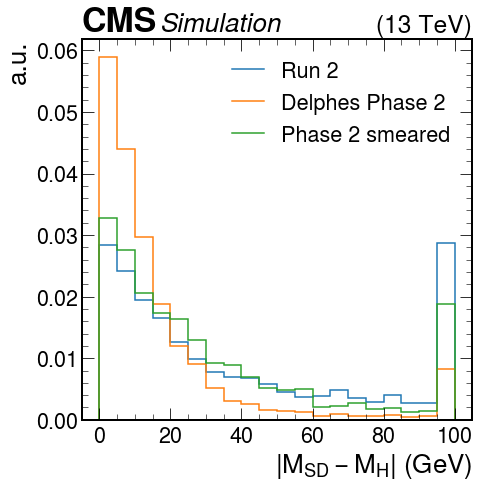

In [89]:
fig, ax = plt.subplots(1,1,figsize=(7,7))

hep.cms.label(
    "Simulation",
    data=True,
    #year=2018,
    #lumi=60.0,
    loc=0,
    ax=ax,
)

#vals_tagged = output['tagged'][sname].sum('phi', 'mass', 'eta', 'dataset').values()[()]
#vals_inclusive = output['inclusive'][sname].sum('phi', 'mass', 'eta', 'dataset').values()[()]

hep.histplot(
    [ h_mSD_res_full.counts, h_mSD_res.counts, h_mSD_res_smeared.counts ],
    h_mSD_res.edges,
    #w2=[ vals_tagged, vals_inclusive ],
    histtype="step",
    stack=False,
    label=['Run 2', 'Delphes Phase 2', 'Phase 2 smeared'],
    #color=[ my_histos[x].color for x in keys ],
    ax=ax,density=True)

ax.legend()

ax.set_xlabel(r'$|M_{SD}-M_{H}|\ (GeV)$')
ax.set_ylabel(r'a.u.')

plt.show()

fig.savefig('/home/users/dspitzba/public_html/HbbMET/MSD_res.png')
fig.savefig('/home/users/dspitzba/public_html/HbbMET/MSD_res.pdf')




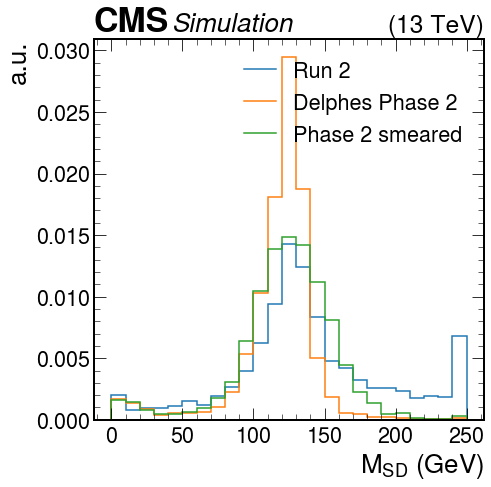

In [125]:
fig, ax = plt.subplots(1,1,figsize=(7,7))

hep.cms.label(
    "Simulation",
    data=True,
    #year=2018,
    #lumi=60.0,
    loc=0,
    ax=ax,
)

hep.histplot(
    [ h_mSD_full.counts, h_mSD.counts, h_mSD_smeared.counts ],
    h_mSD.edges,
    #w2=[ vals_tagged, vals_inclusive ],
    histtype="step",
    stack=False,
    label=['Run 2', 'Delphes Phase 2', 'Phase 2 smeared'],
    #color=[ my_histos[x].color for x in keys ],
    ax=ax,density=True)

ax.legend()

ax.set_xlabel(r'$M_{SD}\ (GeV)$')
ax.set_ylabel(r'a.u.')

plt.show()

fig.savefig('/home/users/dspitzba/public_html/HbbMET/MSD.png')
fig.savefig('/home/users/dspitzba/public_html/HbbMET/MSD.pdf')



In [58]:
ratio = (h_mSD_res_full.counts/sum(h_mSD_res_full.counts))/(h_mSD_res.counts/sum(h_mSD_res.counts))
ratio

array([0.48282055, 0.55076199, 0.65847323, 0.8809465 , 1.06217878,
       1.08467679, 1.47045747, 2.23217271, 2.72439541, 3.69167025,
       3.14353316, 3.05948147, 6.85105316, 4.8077566 , 6.25008358,
       5.16833835, 5.15116779, 6.31018054, 4.92795052, 3.50769997])

In [64]:
norm_ratio = ratio/sum(ratio)
norm_ratio

array([0.00754221, 0.00860353, 0.01028611, 0.01376139, 0.01659245,
       0.01694389, 0.02297023, 0.03486909, 0.04255817, 0.05766811,
       0.04910558, 0.0477926 , 0.10702129, 0.07510266, 0.09763345,
       0.08073536, 0.08046713, 0.09857224, 0.07698022, 0.05479429])

In [63]:
np.random.choice(h_mSD_res_full.edges[:-1], 10, p=norm_ratio)

array([95., 25., 65., 90., 85., 80., 65., 50., 45., 70.])

In [66]:
Hist1D(
    np.random.choice(h_mSD_res_full.edges[:-1], 10000, p=norm_ratio),
    bins=h_mSD_res_full.edges[:-1]
)

[75.00 ± 8.66   83.00 ± 9.11   97.00 ± 9.85   140.00 ± 11.83
 140.00 ± 11.83   178.00 ± 13.34   238.00 ± 15.43   373.00 ± 19.31
 424.00 ± 20.59   552.00 ± 23.49   515.00 ± 22.69   468.00 ± 21.63
 1071.00 ± 32.73   770.00 ± 27.75   964.00 ± 31.05   766.00 ± 27.68
 779.00 ± 27.91   1049.00 ± 32.39   1318.00 ± 36.30]

In [77]:
np.random.normal(loc=2.0, scale=1.0, size=1)

array([2.42929437])

In [82]:
Hist1D(
    np.random.normal(loc=1.0, scale=1.0, size=100000),
    #bins=h_mSD_res_full.edges[:-1]
)

[ 1.00 ± 1.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
  0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
  1.00 ± 1.00    3.00 ± 1.73    1.00 ± 1.00    0.00 ± 0.00    2.00 ± 1.41
  1.00 ± 1.00    0.00 ± 0.00    2.00 ± 1.41    2.00 ± 1.41    2.00 ± 1.41
  5.00 ± 2.24    4.00 ± 2.00   15.00 ± 3.87   16.00 ± 4.00    9.00 ± 3.00
 18.00 ± 4.24   17.00 ± 4.12   31.00 ± 5.57   25.00 ± 5.00   26.00 ± 5.10
 32.00 ± 5.66   54.00 ± 7.35   57.00 ± 7.55   71.00 ± 8.43   66.00 ± 8.12
 79.00 ± 8.89   104.00 ± 10.20   115.00 ± 10.72   128.00 ± 11.31
 145.00 ± 12.04   164.00 ± 12.81   209.00 ± 14.46   218.00 ± 14.76
 222.00 ± 14.90   291.00 ± 17.06   349.00 ± 18.68   334.00 ± 18.28
 402.00 ± 20.05   422.00 ± 20.54   490.00 ± 22.14   548.00 ± 23.41
 596.00 ± 24.41   700.00 ± 26.46   621.00 ± 24.92   770.00 ± 27.75
 794.00 ± 28.18   875.00 ± 29.58   971.00 ± 31.16   1088.00 ± 32.98
 1220.00 ± 34.93   1210.00 ± 34.79   1319.00 ± 36.32   1400.00 ± 37.42
 1394.00 ± 37.34   1517.00 ± 38.95   1561.00 ± 39.51   1700.00 ± 41.23
 1758.00 ± 41.93   1962.00 ± 44.29   1871.00 ± 43.26   1987.00 ± 44.58
 2068.00 ± 45.48   2039.00 ± 45.16   2194.00 ± 46.84   2216.00 ± 47.07
 2283.00 ± 47.78   2234.00 ± 47.27   2205.00 ± 46.96   2275.00 ± 47.70
 2250.00 ± 47.43   2357.00 ± 48.55   2343.00 ± 48.40   2225.00 ± 47.17
 2246.00 ± 47.39   2252.00 ± 47.46   2229.00 ± 47.21   2145.00 ± 46.31
 2057.00 ± 45.35   2069.00 ± 45.49   2001.00 ± 44.73   1905.00 ± 43.65
 1935.00 ± 43.99   1849.00 ± 43.00   1662.00 ± 40.77   1644.00 ± 40.55
 1546.00 ± 39.32   1486.00 ± 38.55   1366.00 ± 36.96   1294.00 ± 35.97
 1231.00 ± 35.09   1124.00 ± 33.53   1046.00 ± 32.34   975.00 ± 31.22
 943.00 ± 30.71   838.00 ± 28.95   814.00 ± 28.53   693.00 ± 26.32
 662.00 ± 25.73   591.00 ± 24.31   526.00 ± 22.93   495.00 ± 22.25
 455.00 ± 21.33   397.00 ± 19.92   366.00 ± 19.13   312.00 ± 17.66
 296.00 ± 17.20   231.00 ± 15.20   217.00 ± 14.73   192.00 ± 13.86
 183.00 ± 13.53   145.00 ± 12.04   148.00 ± 12.17   125.00 ± 11.18
 104.00 ± 10.20   85.00 ± 9.22   71.00 ± 8.43   57.00 ± 7.55
 60.00 ± 7.75   44.00 ± 6.63   32.00 ± 5.66   32.00 ± 5.66   27.00 ± 5.20
 18.00 ± 4.24   14.00 ± 3.74   11.00 ± 3.32   10.00 ± 3.16    6.00 ± 2.45
  7.00 ± 2.65    8.00 ± 2.83    6.00 ± 2.45    4.00 ± 2.00    5.00 ± 2.24
  3.00 ± 1.73    6.00 ± 2.45    4.00 ± 2.00    2.00 ± 1.41    2.00 ± 1.41
  0.00 ± 0.00    2.00 ± 1.41    1.00 ± 1.00    0.00 ± 0.00    2.00 ± 1.41
  0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
  0.00 ± 0.00    2.00 ± 1.41]

In [84]:
smear_by = 1+np.maximum(np.random.normal(loc=1.0, scale=1.0, size=100), 0)
smear_by

array([2.76845974, 3.67201455, 1.77793517, 3.8684992 , 2.24683549,
       3.64144616, 1.63474238, 1.75471108, 1.        , 1.        ,
       1.        , 1.20421962, 1.92189693, 1.83474238, 3.85364678,
       2.19857843, 2.13578731, 1.        , 2.42569519, 2.24419665,
       1.        , 1.78143674, 1.86343405, 2.36866955, 1.        ,
       2.1997423 , 2.75857359, 1.        , 2.58294438, 2.06028345,
       1.99346926, 2.34914728, 1.        , 1.33585615, 4.63930762,
       3.57177733, 2.83516974, 1.        , 1.        , 4.82585793,
       1.        , 2.12408928, 1.67901766, 2.69108282, 1.85558529,
       1.83010688, 2.62553626, 2.98362838, 1.53059093, 2.51548836,
       2.29255707, 1.        , 1.29292692, 2.90989706, 1.83392698,
       1.11685802, 2.59826727, 2.13577333, 1.44711325, 1.        ,
       1.71608107, 1.        , 3.92152826, 2.16181485, 1.        ,
       2.70932045, 2.9794884 , 3.58210372, 1.5825429 , 2.11998341,
       2.82906918, 3.69589386, 3.52362301, 4.3639307 , 4.13156

## Get the efficiencies

In [7]:
from analysis.tagger import measure_eff


output = processor.run_uproot_job(
            fileset,
            "Events",
            measure_eff(accumulator=desired_output),
            exe,
            exe_args,
            chunksize=500000,
        )

Preprocessing:   0%|          | 0/60 [00:00<?, ?file/s]

Processing:   0%|          | 0/82 [00:00<?, ?chunk/s]

In [8]:
def get_efficiency(region, process, mass_range=slice(100,150)):

    pt_bins  = hist.Bin('pt', r'$p_{T} \ (GeV)$', [200, 300, 400, 600, 800])
    eta_bins = hist.Bin('eta', r'$\eta$', 3, 0, 2.4)

    inclusive = output[region][process].rebin('pt', pt_bins).rebin('eta', eta_bins)
    tagged = output[region+'_tagged'][process].rebin('pt', pt_bins).rebin('eta', eta_bins)

    h1 = Hist2D.from_bincounts(
        inclusive.integrate('mass', int_range=mass_range).sum('phi', 'dataset').values()[()].T,
        (
            inclusive.axis('pt').edges(),
            inclusive.axis('eta').edges(),
        )
    )
    
    h2 = Hist2D.from_bincounts(
        tagged.integrate('mass', int_range=mass_range).sum('phi', 'dataset').values()[()].T,
        (
            tagged.axis('pt').edges(),
            tagged.axis('eta').edges(),
        )
    )
    

    return h2.divide(h1)

In [9]:
# check that stuff actually ran

output['1b'].sum('phi', 'mass').integrate('eta', slice(0,1)).integrate('pt', slice(500,1000)).values()

{('ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8',): 82.0,
 ('ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8',): 156.0,
 ('ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8',): 554.0,
 ('ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8',): 288.0,
 ('TT_Mtt-1000toInf_TuneCP5_13TeV-powheg-pythia8',): 40075.0,
 ('TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8',): 6555.0}

In [10]:
output['1h_tagged'].sum('phi', 'mass').integrate('eta', slice(0,1)).integrate('pt', slice(500,1000)).values()

{('ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8',): 0.0,
 ('ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8',): 0.0,
 ('ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8',): 0.0,
 ('ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8',): 0.0,
 ('TT_Mtt-1000toInf_TuneCP5_13TeV-powheg-pythia8',): 0.0,
 ('TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8',): 0.0}

In [79]:
6534.0/10065.0

0.6491803278688525

TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8
TT_Mtt-1000toInf_TuneCP5_13TeV-powheg-pythia8
ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8
ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8
ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8
ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8


(<matplotlib.image.PcolorImage at 0x7f942839d9a0>, <AxesSubplot:>)

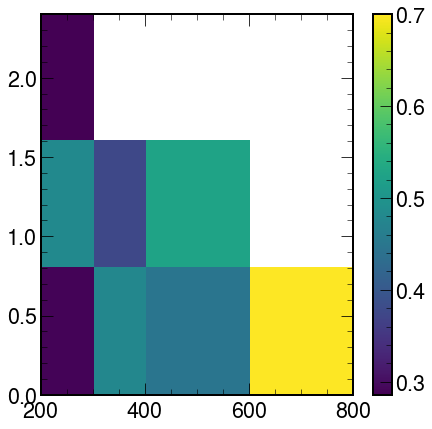

In [12]:
for s in fileset.keys():
    print (s)
    for b in ['0b', '1b', '2b', '1h']:
        #print (b)
        h = get_efficiency(b, s, mass_range=slice(0,500))
        #h.plot()

        h.to_json(os.path.expandvars("../data/htag/eff_%s_%s.json"%(s,b)))
        
        #del h
    
h = get_efficiency(
    '2b',
    'ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8',
    mass_range=slice(0,500),
)
fig, ax = plt.subplots(1,1,figsize=(7,7))
h.plot()

(<matplotlib.image.PcolorImage at 0x7f92503ccc70>, <AxesSubplot:>)

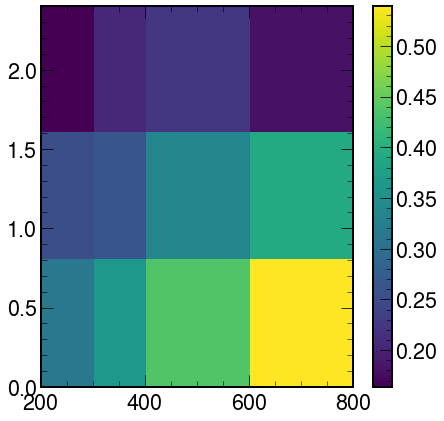

In [17]:
h = get_efficiency(
    '2b',
    'TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8',
    mass_range=slice(0,500),
)
fig, ax = plt.subplots(1,1,figsize=(7,7))
h.plot()

## Apply the efficiency

In [93]:
effs = {}
for s in fileset_Z.keys():
    effs[s] = {}
    print (s)
    for b in ['0b', '1b', '2b', '1h']:
        #print (b)
        #h = get_efficiency(b, s, mass_range=slice(0,500))
        #h.plot()
        effs[s][b] = Hist2D.from_json(os.path.expandvars("../data/htag/eff_%s_%s.json"%(s,b)))
        #effs[s][b] = effs[s][b]*0.95
        
for s in fileset.keys():
    effs[s] = {}
    print (s)
    for b in ['0b', '1b', '2b', '1h']:
        #print (b)
        #h = get_efficiency(b, s, mass_range=slice(0,500))
        #h.plot()
        effs[s][b] = Hist2D.from_json(os.path.expandvars("../data/htag/eff_%s_%s.json"%(s,b)))
        #effs[s][b] = effs[s][b]*0.95

ZJetsToNuNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8
ZJetsToNuNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8
ZJetsToNuNu_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8
ZJetsToNuNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8
ZJetsToNuNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8
ZJetsToNuNu_HT-1200To2500_TuneCP5_13TeV-madgraphMLM-pythia8
ZJetsToNuNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8
ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8


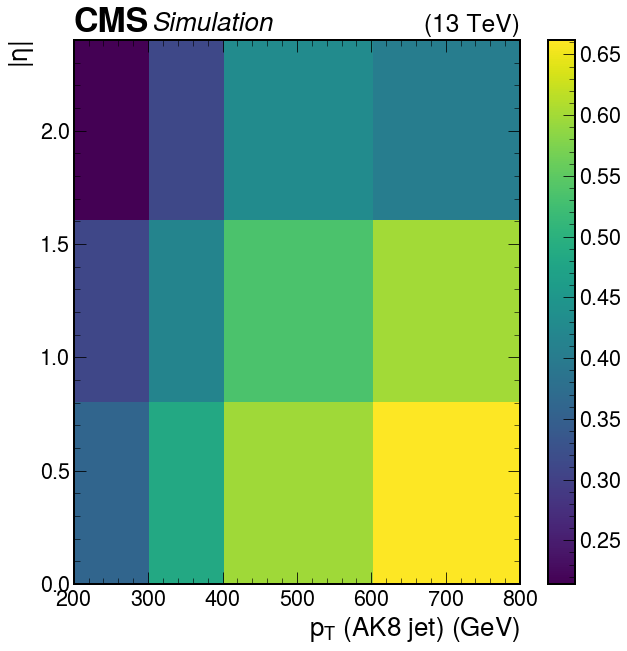

In [94]:
fig, ax = plt.subplots()

hep.cms.label(
    "Simulation",
    data=True,
    #year=2018,
    #lumi=60.0,
    loc=0,
    ax=ax,
)

effs['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8']['1h'].plot()

ax.set_xlabel(r'$p_T\ (AK8\ jet)\ (GeV)$')
ax.set_ylabel(r'$|\eta|$')

plt.show()

fig.savefig('/home/users/dspitzba/public_html/HbbMET/1h_true_eff.png')
fig.savefig('/home/users/dspitzba/public_html/HbbMET/1h_true_eff.pdf')


In [42]:
effs['ZJetsToNuNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8']['1b']*1.05

[[ 0.27 ± 0.01    0.18 ± 0.01    0.16 ± 0.01    0.18 ± 0.02]
 [ 0.20 ± 0.01    0.12 ± 0.01    0.11 ± 0.01    0.10 ± 0.02]
 [ 0.09 ± 0.01    0.07 ± 0.01    0.05 ± 0.01    0.02 ± 0.02]]

In [43]:
effs['ZJetsToNuNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8']['1b'].counts

array([[0.26036866, 0.17354754, 0.1568438 , 0.17021277],
       [0.19107622, 0.11665128, 0.10434057, 0.09259259],
       [0.08163265, 0.06629834, 0.04867257, 0.01449275]])

In [44]:
np.isnan(sum(sum(effs['ZJetsToNuNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8']['1h'].counts)))

True

In [45]:
from tools.helpers import yahist_2D_lookup
yahist_2D_lookup(
    effs['ZJetsToNuNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8']['0b'],
    ak.Array([[700]]),
    ak.Array([[2.]]),
)

<Array [[0.00195]] type='1 * var * float64'>

In [97]:
from analysis.tagger import apply_eff, desired_output

exe_args = {
    'workers': 12,
    "schema": NanoAODSchema,
    "skipbadfiles": True,
}

output = processor.run_uproot_job(
            fileset_Z,
            "Events",
            apply_eff(
                accumulator=desired_output,
                effs = effs,
            ),
            exe,
            exe_args,
            chunksize=500000,
        )

Processing:   0%|          | 0/218 [00:00<?, ?chunk/s]

### Closure and sanity checks

Make sure that the method closes in pt, and gives reasonable agreement in the mass distribution.


In [98]:
# if inclusive number below is nan we have a bug in applying the efficiencies.
output['inclusive'].sum('pt', 'eta', 'phi', 'mass').values()

{('ZJetsToNuNu_HT-1200To2500_TuneCP5_13TeV-madgraphMLM-pythia8',): 2261.29967650816,
 ('ZJetsToNuNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8',): 843.6441674018162,
 ('ZJetsToNuNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8',): 8717.163300381211,
 ('ZJetsToNuNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8',): 14786.910422661294,
 ('ZJetsToNuNu_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8',): 27094.156602625975,
 ('ZJetsToNuNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8',): 12060.999999999998,
 ('ZJetsToNuNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8',): 330.0}

In [99]:
# inclusive and tagged numbers should agree within percent level
output['tagged'].sum('pt', 'eta', 'phi', 'mass').values()

{('ZJetsToNuNu_HT-1200To2500_TuneCP5_13TeV-madgraphMLM-pythia8',): 2360.0,
 ('ZJetsToNuNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8',): 929.0,
 ('ZJetsToNuNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8',): 8828.0,
 ('ZJetsToNuNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8',): 14795.0,
 ('ZJetsToNuNu_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8',): 27094.0,
 ('ZJetsToNuNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8',): 12061.0,
 ('ZJetsToNuNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8',): 331.0}

In [110]:
output['tagged'][sname].sum('phi', 'mass', 'eta', 'dataset').values(sumw2=True)

{(): (array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.539e+03, 1.257e+03,
         1.081e+03, 1.016e+03, 8.070e+02, 7.090e+02, 6.630e+02, 6.800e+02,
         6.940e+02, 7.590e+02, 7.310e+02, 7.420e+02, 6.430e+02, 6.130e+02,
         4.960e+02, 4.330e+02, 3.150e+02, 2.950e+02, 2.610e+02, 2.190e+02,
         1.960e+02, 1.630e+02, 1.420e+02, 9.300e+01, 6.300e+01, 6.100e+01,
         4.700e+01, 3.000e+01, 1.800e+01, 7.000e+00, 1.500e+01, 6.000e+00,
         1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00]),
  array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.539e+03, 1.257e+03,
         1.081e+03, 1.016e+03, 8.070e+02, 7.090e+02, 6.630e+02, 6.800e+02,
         6.940e+02, 7.590e+02, 7.310e+02, 7.420e+02, 6.430e+02, 6.130e+02,
         4.960e+02, 4.330e+02, 3.150e+02, 2.950e+02, 2.610e+02,

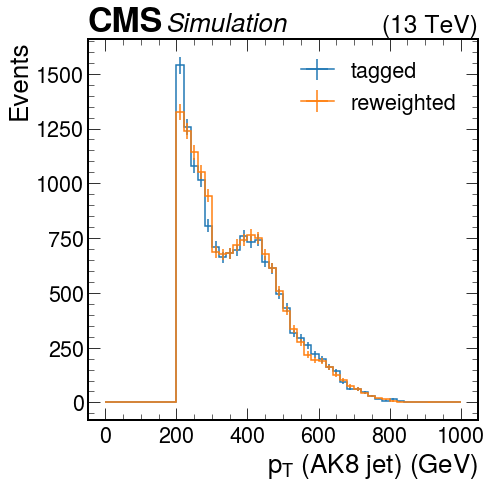

In [111]:
fig, ax = plt.subplots(1,1,figsize=(7,7))

hep.cms.label(
    "Simulation",
    data=True,
    #year=2018,
    #lumi=60.0,
    loc=0,
    ax=ax,
)

sname = 'ZJetsToNuNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8'

vals_tagged = output['tagged'][sname].sum('phi', 'mass', 'eta', 'dataset').values()[()]
vals_inclusive = output['inclusive'][sname].sum('phi', 'mass', 'eta', 'dataset').values()[()]

hep.histplot(
    [ vals_tagged, vals_inclusive ],
    output['inclusive'][sname].axis('pt').edges(),
    w2=[ vals_tagged, vals_inclusive ],
    histtype="step",
    stack=False,
    label=['tagged', 'reweighted'],
    #color=[ my_histos[x].color for x in keys ],
    ax=ax)

ax.legend()

ax.set_xlabel(r'$p_T\ (AK8\ jet)\ (GeV)$')
ax.set_ylabel(r'Events')

plt.show()

fig.savefig('/home/users/dspitzba/public_html/HbbMET/tagging/application_pt.png')
fig.savefig('/home/users/dspitzba/public_html/HbbMET/tagging/application_pt.pdf')



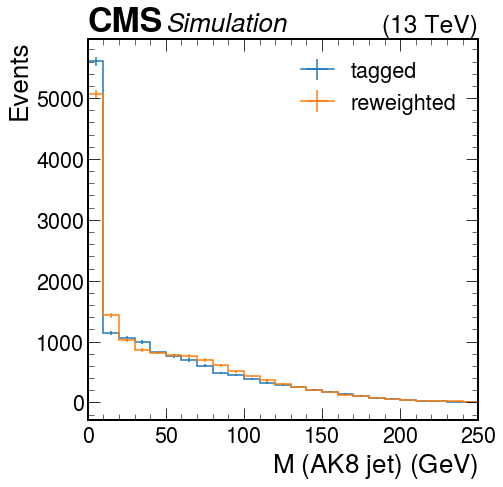

In [114]:
fig, ax = plt.subplots(1,1,figsize=(7,7))

hep.cms.label(
    "Simulation",
    data=True,
    #year=2018,
    #lumi=60.0,
    loc=0,
    ax=ax,
)

sname = 'ZJetsToNuNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8'

vals_tagged = output['tagged'][sname].sum('phi', 'pt', 'eta', 'dataset').values()[()]
vals_inclusive = output['inclusive'][sname].sum('phi', 'pt', 'eta', 'dataset').values()[()]

hep.histplot(
    [ vals_tagged, vals_inclusive ],
    output['inclusive'][sname].axis('mass').edges(),
    w2=[ vals_tagged, vals_inclusive ],
    histtype="step",
    stack=False,
    label=['tagged', 'reweighted'],
    #color=[ my_histos[x].color for x in keys ],
    ax=ax)

ax.legend()

ax.set_xlabel(r'$M\ (AK8\ jet)\ (GeV)$')
ax.set_ylabel(r'Events')

ax.set_xlim([0,250])

plt.show()

fig.savefig('/home/users/dspitzba/public_html/HbbMET/tagging/application_mass.png')
fig.savefig('/home/users/dspitzba/public_html/HbbMET/tagging/application_mass.pdf')



<AxesSubplot:>

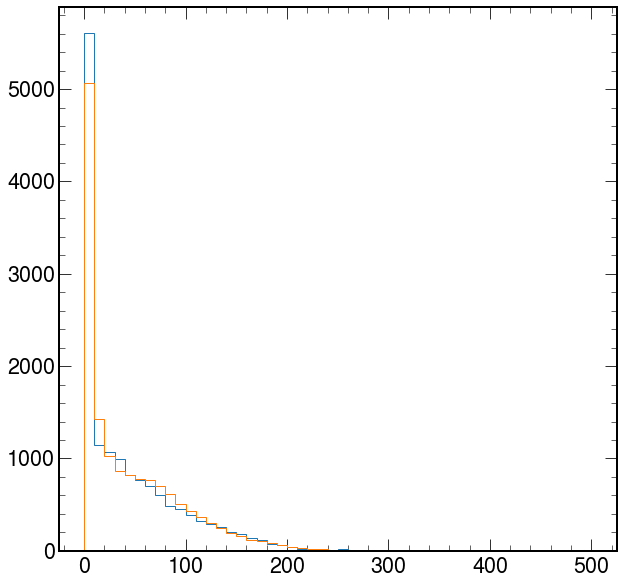

In [50]:
h1 = Hist1D.from_bincounts(
        output['tagged'][sname].sum('phi', 'pt', 'eta', 'dataset').values()[()],
        output['tagged'][sname].axis('mass').edges(),
    )

h2 = Hist1D.from_bincounts(
        output['inclusive'][sname].sum('phi', 'pt', 'eta', 'dataset').values()[()],
        output['inclusive'][sname].axis('mass').edges(),
    )
h1.plot()
h2.plot()

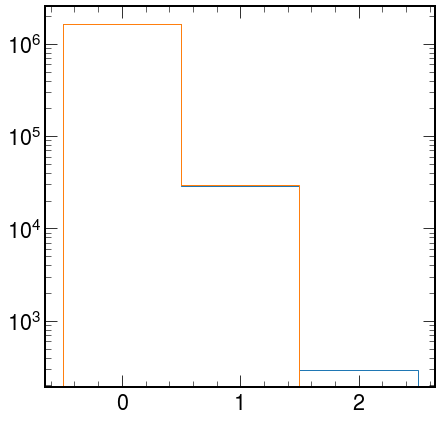

In [51]:
fig, ax = plt.subplots(1,1,figsize=(7,7))

h1 = Hist1D.from_bincounts(
        output['NH_true'][sname].sum('dataset').values()[()],
        output['NH_true'][sname].axis('multiplicity').edges(),
    )

h2 = Hist1D.from_bincounts(
        output['NH_weight'][sname].sum('dataset').values()[()],
        output['NH_weight'][sname].axis('multiplicity').edges(),
    )
h1.plot()
h2.plot()

ax.set_yscale('log')

### Compare prediction of tagged jets in the interesting mass window

In [52]:
output['inclusive'][sname].integrate('mass', int_range=slice(100,150)).sum('phi', 'pt', 'eta', 'dataset').values()[()]

1539.101715319699

In [53]:
output['tagged'][sname].integrate('mass', int_range=slice(100,150)).sum('phi', 'pt', 'eta', 'dataset').values()[()]

1462.0

In [54]:
1539.101715319699/1462.0

1.052737151381463

In [ ]:
test_eff = ak.Array([[0.1,0.2], [0.15], []])
1-ak.prod(1-test_eff, axis=1)

In [ ]:
np.zeros_like(ak.num(test_eff))

In [39]:
output['NH_true'][sname].values()

{('ZJetsToNuNu_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8',): array([1.348125e+06, 1.727500e+04, 4.100000e+01])}

In [40]:
output['NH_weight'][sname].values()

{('ZJetsToNuNu_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8',): array([1347971.26474227,   17205.73525705,       0.        ])}

In [ ]:
54281.68960112/(5.3884000e+04+1.7600000e+02)

## WIP

In [ ]:
def compute_darkness(r, g, b, a=1.0):
    """Compute the 'darkness' value from RGBA (darkness = 1 - luminance)
       stolen from Nick Amin: https://github.com/aminnj/yahist
       Version from Jonathan Guiang: https://gist.github.com/jkguiang/279cb4d2e68e64148afc62274df09f18
    """
    return a * (1.0 - (0.299 * r + 0.587 * g + 0.114 * b))

def bin_text(counts, x_edges, y_edges, axes, cbar, errors=None, size=10, fmt=":0.2e"):
    """Write bin population on top of 2D histogram bins,
       stolen from Nick Amin: https://github.com/aminnj/yahist
       Version from Jonathan Guiang: https://gist.github.com/jkguiang/279cb4d2e68e64148afc62274df09f18
    """
    show_errors = (type(errors) != type(None))
    x_centers = x_edges[1:]-(x_edges[1:]-x_edges[:-1])/2
    y_centers = y_edges[1:]-(y_edges[1:]-y_edges[:-1])/2
    
    if show_errors:
        label_template = r"{0"+fmt+"}\n$\pm{1:0.2f}\%$"
    else:
        errors = np.zeros(counts.shape)
        label_template = r"{0"+fmt+"}"
        
    xyz = np.c_[        
        np.tile(x_centers, len(y_centers)),
        np.repeat(y_centers, len(x_centers)),
        counts.flatten(),
        errors.flatten()
    ][counts.flatten() != 0]

    r, g, b, a = cbar.mappable.to_rgba(xyz[:, 2]).T
    colors = np.zeros((len(xyz), 3))
    colors[compute_darkness(r, g, b, a) > 0.45] = 1

    for (x, y, count, err), color in zip(xyz, colors):
        axes.text(
            x,
            y,
            label_template.format(count, err),
            color=color,
            ha="center",
            va="center",
            fontsize=size,
            wrap=True,
        )

    return

In [ ]:
h2.divide(h1).counts

In [ ]:
h2.edges[0]